# 🧠 Model Training & Progress — Combined UCI Heart Dataset

This notebook retrains all models on the unified `combined_uci_heart` dataset and visualizes:

- Final metrics (Accuracy, AUC)
- Confusion matrices
- Training curves (loss/accuracy per epoch) for Neural Network and Transformer models.


In [1]:
# ================================================================
# 🩺 Model Training on Combined UCI Heart Dataset (Updated Version)
# ================================================================
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import os, joblib, numpy as np, pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# ================================================================
# 🧹 CLEANUP: Reset Results and Figures Directories
# ================================================================
import shutil

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")
FIG_DIR = os.path.join(BASE_DIR, "experiments", "figures")

# Delete old folders if they exist
for path in [RESULTS_DIR, FIG_DIR]:
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"🗑️ Deleted old folder: {path}")

# Recreate clean folders
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("✅ Clean directories ready:")
print(f"  Results → {RESULTS_DIR}")
print(f"  Figures → {FIG_DIR}")


# ------------------------------------------------
# Paths
# ------------------------------------------------
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")
FIG_DIR = os.path.join(BASE_DIR, "experiments", "figures")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------------------------
# Load dataset
# ------------------------------------------------
dataset_name = "combined_uci_heart"
X_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_X.joblib")
y_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_y.joblib")

X = joblib.load(X_path)
y = joblib.load(y_path)

if hasattr(X, "toarray"):
    X = X.toarray()

# Convert to DataFrame for safety
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

# Drop non-numeric columns (e.g. "source")
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"🧹 Dropping non-numeric columns: {non_numeric}")
    X = X.drop(columns=non_numeric)

# Handle missing values
X = X.fillna(X.median())

# Normalize numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("✅ Loaded and cleaned data:", X_scaled.shape)
print("Target distribution:", np.bincount(y))

# ------------------------------------------------
# Split data
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# ------------------------------------------------
# 1️⃣ Logistic Regression
# ------------------------------------------------
logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

log_acc = accuracy_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_proba)
print(f"\n📊 Logistic Regression — Accuracy: {log_acc:.3f} | AUC: {log_auc:.3f}")

joblib.dump(logreg, os.path.join(RESULTS_DIR, "logistic_regression_combined_uci_heart_model.joblib"))

# ------------------------------------------------
# 2️⃣ SVM
# ------------------------------------------------
svm = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

svm_acc = accuracy_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_proba)
print(f"📊 SVM — Accuracy: {svm_acc:.3f} | AUC: {svm_auc:.3f}")

joblib.dump(svm, os.path.join(RESULTS_DIR, "svm_combined_uci_heart_model.joblib"))

# ------------------------------------------------
# 3️⃣ XGBoost
# ------------------------------------------------
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_proba)
print(f"📊 XGBoost — Accuracy: {xgb_acc:.3f} | AUC: {xgb_auc:.3f}")

joblib.dump(xgb, os.path.join(RESULTS_DIR, "xgboost_combined_uci_heart_model.joblib"))

# ------------------------------------------------
# Save Metrics
# ------------------------------------------------
metrics = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": log_acc, "AUC": log_auc},
    {"Model": "SVM", "Accuracy": svm_acc, "AUC": svm_auc},
    {"Model": "XGBoost", "Accuracy": xgb_acc, "AUC": xgb_auc},
])
metrics_path = os.path.join(RESULTS_DIR, "combined_uci_heart_model_metrics.csv")
metrics.to_csv(metrics_path, index=False)

print("\n✅ Training complete. Metrics saved to:", metrics_path)
display(metrics)


🗑️ Deleted old folder: c:\Users\user\CardioVescular_Disease_prediction\experiments\results
🗑️ Deleted old folder: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures
✅ Clean directories ready:
  Results → c:\Users\user\CardioVescular_Disease_prediction\experiments\results
  Figures → c:\Users\user\CardioVescular_Disease_prediction\experiments\figures
🧹 Dropping non-numeric columns: ['source']
✅ Loaded and cleaned data: (916, 13)
Target distribution: [409 507]
Train: (732, 13) Test: (184, 13)

📊 Logistic Regression — Accuracy: 0.837 | AUC: 0.919
📊 SVM — Accuracy: 0.848 | AUC: 0.928
📊 XGBoost — Accuracy: 0.853 | AUC: 0.902

✅ Training complete. Metrics saved to: c:\Users\user\CardioVescular_Disease_prediction\experiments\results\combined_uci_heart_model_metrics.csv


,Model,Accuracy,AUC
0,Logistic Regression,0.836957,0.918699
1,SVM,0.847826,0.928384
2,XGBoost,0.853261,0.902080


Epoch [5/40] - Loss: 0.4308
Epoch [10/40] - Loss: 0.4159
Epoch [15/40] - Loss: 0.3999
Epoch [20/40] - Loss: 0.3909
Epoch [25/40] - Loss: 0.3786
Epoch [30/40] - Loss: 0.3638
Epoch [35/40] - Loss: 0.3617
Epoch [40/40] - Loss: 0.3525

📊 Neural Network — Accuracy: 0.837 | AUC: 0.930


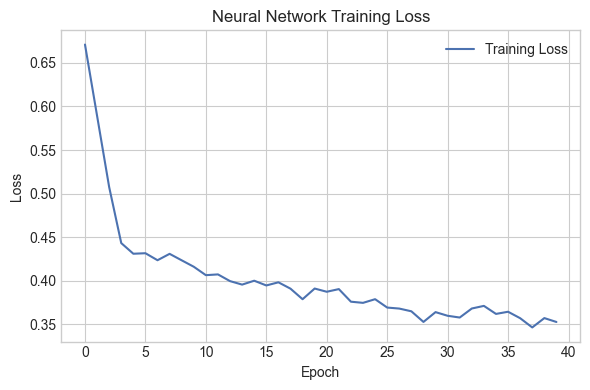

In [2]:
# ================================================================
# 🧠 Neural Network (Multilayer Perceptron) — PyTorch (Fixed)
# ================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- Safe tensor conversion (handles numpy or DataFrame) ---
def to_tensor(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
        x = x.to_numpy()
    return torch.tensor(x, dtype=torch.float32)

X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train).unsqueeze(1)
X_test_tensor = to_tensor(X_test)
y_test_tensor = to_tensor(y_test).unsqueeze(1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# --- Define the model ---
class HeartMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

nn_model = HeartMLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# --- Training loop ---
n_epochs = 40
train_losses = []
for epoch in range(n_epochs):
    nn_model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = nn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {train_losses[-1]:.4f}")

# --- Evaluation ---
nn_model.eval()
with torch.no_grad():
    nn_probs = nn_model(X_test_tensor).numpy().flatten()
    nn_preds = (nn_probs > 0.5).astype(int)

nn_acc = accuracy_score(y_test, nn_preds)
nn_auc = roc_auc_score(y_test, nn_probs)
print(f"\n📊 Neural Network — Accuracy: {nn_acc:.3f} | AUC: {nn_auc:.3f}")

# --- Save model + metrics ---
torch.save(nn_model.state_dict(), os.path.join(RESULTS_DIR, "neural_network_combined_uci_heart_model.pt"))
joblib.dump(nn_probs, os.path.join(RESULTS_DIR, "neural_network_combined_uci_heart_yproba.joblib"))

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Neural Network Training Loss")
plt.legend()
plt.tight_layout()
plt.show()



Epoch [5/40] - Loss: 0.3972
Epoch [10/40] - Loss: 0.3528
Epoch [15/40] - Loss: 0.2999
Epoch [20/40] - Loss: 0.2963
Epoch [25/40] - Loss: 0.2521
Epoch [30/40] - Loss: 0.2288
Epoch [35/40] - Loss: 0.2337
Epoch [40/40] - Loss: 0.1685

📊 Transformer — Accuracy: 0.810 | AUC: 0.856


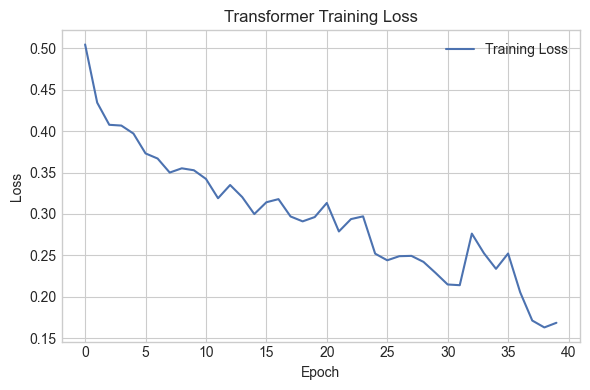

In [3]:
# ================================================================
# 🔁 Transformer Model for Tabular Data (Fixed + Cleaned)
# ================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- Safe tensor conversion (handles numpy or DataFrame) ---
def to_tensor(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
        x = x.to_numpy()
    return torch.tensor(x, dtype=torch.float32)

X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train).unsqueeze(1)
X_test_tensor = to_tensor(X_test)
y_test_tensor = to_tensor(y_test).unsqueeze(1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# --- Define a simple Transformer encoder for tabular data ---
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=2, num_layers=2, hidden_dim=64):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)  # add sequence dim
        x = self.encoder(x)
        x = x.mean(dim=1)  # global average pooling
        return self.sigmoid(self.fc(x))

# --- Initialize model, optimizer, loss ---
transformer_model = SimpleTransformer(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# --- Training loop ---
epochs = 40
losses = []
for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = transformer_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {losses[-1]:.4f}")

# --- Evaluation ---
transformer_model.eval()
with torch.no_grad():
    tr_probs = transformer_model(X_test_tensor).numpy().flatten()
    tr_preds = (tr_probs > 0.5).astype(int)

tr_acc = accuracy_score(y_test, tr_preds)
tr_auc = roc_auc_score(y_test, tr_probs)
print(f"\n📊 Transformer — Accuracy: {tr_acc:.3f} | AUC: {tr_auc:.3f}")

# --- Save model + predictions ---
torch.save(transformer_model.state_dict(), os.path.join(RESULTS_DIR, "transformer_combined_uci_heart_model.pt"))
joblib.dump(tr_probs, os.path.join(RESULTS_DIR, "transformer_combined_uci_heart_yproba.joblib"))

# --- Plot training loss ---
plt.figure(figsize=(6, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import os, joblib, numpy as np, pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")
FIG_DIR = os.path.join(BASE_DIR, "experiments", "figures")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

dataset_name = "combined_uci_heart"
X_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_X.joblib")
y_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_y.joblib")

X = joblib.load(X_path)
y = joblib.load(y_path)

# Convert to DataFrame if needed (for feature cleanup)
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)
if hasattr(X, "toarray"):
    X = X.toarray()

# Drop non-numeric metadata columns if present
drop_cols = [col for col in X.columns if any(k in col.lower() for k in ["source", "dataset", "id", "index"])]
if drop_cols:
    print("🧹 Dropping metadata columns:", drop_cols)
    X = X.drop(columns=drop_cols)

# Identify any object/categorical columns and encode
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
if cat_cols:
    print("🔤 Encoding categorical columns:", cat_cols)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Replace missing values
if X.isnull().any().any():
    print("⚠️ Missing values found — filling with median")
    X = X.fillna(X.median())

# Ensure numeric type for models
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# Scale data for numeric stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Loaded X:", X.shape, "y:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("📊 Train:", X_train.shape, "Test:", X_test.shape)


🧹 Dropping metadata columns: ['source']
⚠️ Missing values found — filling with median
✅ Loaded X: (916, 13) y: (916,)
📊 Train: (732, 13) Test: (184, 13)


## 📦 Helper: plotting training curves

In [5]:
def plot_curve(values, title, ylabel, save_name):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(values)+1), values, marker="o")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.tight_layout()
    save_path = os.path.join(FIG_DIR, save_name)
    plt.savefig(save_path, dpi=200)
    plt.show()
    print("💾 Saved:", save_path)


## 1️⃣ Logistic Regression

In [6]:
logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

logreg_acc = accuracy_score(y_test, y_pred)
logreg_auc = roc_auc_score(y_test, y_proba)
print(f"LogReg — Accuracy: {logreg_acc:.3f}, AUC: {logreg_auc:.3f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


LogReg — Accuracy: 0.837, AUC: 0.919
Confusion matrix:
 [[66 16]
 [14 88]]


## 2️⃣ SVM (RBF kernel)

In [7]:
svm = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:,1]

svm_acc = accuracy_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_proba)
print(f"SVM — Accuracy: {svm_acc:.3f}, AUC: {svm_auc:.3f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


SVM — Accuracy: 0.848, AUC: 0.928
Confusion matrix:
 [[64 18]
 [10 92]]


## 3️⃣ XGBoost

In [8]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

xgb_acc = accuracy_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_proba)
print(f"XGBoost — Accuracy: {xgb_acc:.3f}, AUC: {xgb_auc:.3f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


XGBoost — Accuracy: 0.853, AUC: 0.902
Confusion matrix:
 [[62 20]
 [ 7 95]]


## 4️⃣ Neural Network — training with epoch curves

Using device: cpu
Epoch 1/30 — Loss: 0.6782, Val AUC: 0.914
Epoch 2/30 — Loss: 0.6218, Val AUC: 0.913
Epoch 3/30 — Loss: 0.5348, Val AUC: 0.915
Epoch 4/30 — Loss: 0.4643, Val AUC: 0.915
Epoch 5/30 — Loss: 0.4408, Val AUC: 0.918
Epoch 6/30 — Loss: 0.4333, Val AUC: 0.919
Epoch 7/30 — Loss: 0.4292, Val AUC: 0.921
Epoch 8/30 — Loss: 0.4218, Val AUC: 0.924
Epoch 9/30 — Loss: 0.4364, Val AUC: 0.926
Epoch 10/30 — Loss: 0.4164, Val AUC: 0.927
Epoch 11/30 — Loss: 0.4069, Val AUC: 0.927
Epoch 12/30 — Loss: 0.4099, Val AUC: 0.930
Epoch 13/30 — Loss: 0.4207, Val AUC: 0.930
Epoch 14/30 — Loss: 0.4074, Val AUC: 0.931
Epoch 15/30 — Loss: 0.4012, Val AUC: 0.931
Epoch 16/30 — Loss: 0.4046, Val AUC: 0.931
Epoch 17/30 — Loss: 0.4000, Val AUC: 0.931
Epoch 18/30 — Loss: 0.4063, Val AUC: 0.932
Epoch 19/30 — Loss: 0.4002, Val AUC: 0.932
Epoch 20/30 — Loss: 0.4011, Val AUC: 0.934
Epoch 21/30 — Loss: 0.3972, Val AUC: 0.935
Epoch 22/30 — Loss: 0.3844, Val AUC: 0.935
Epoch 23/30 — Loss: 0.3961, Val AUC: 0.936
Ep

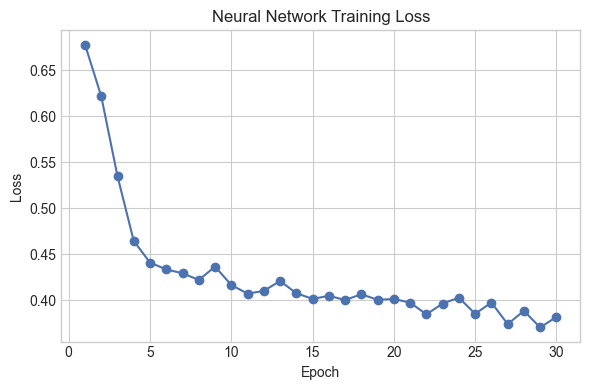

💾 Saved: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\nn_loss_curve.png


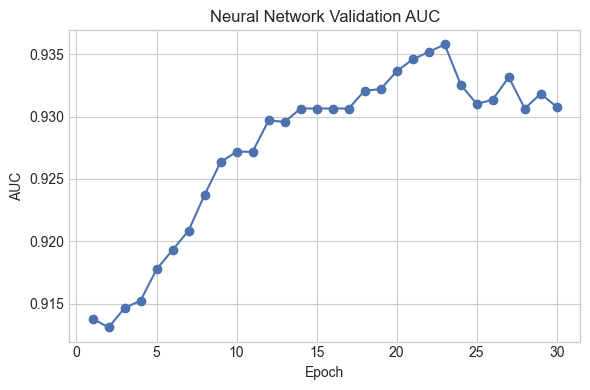

💾 Saved: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\nn_auc_curve.png
Neural Net — Accuracy: 0.832, AUC: 0.931


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

X_train_t = to_tensor(X_train)
X_test_t = to_tensor(X_test)
y_train_t = torch.tensor(y_train.values if hasattr(y_train, "values") else y_train,
                         dtype=torch.float32).view(-1,1)
y_test_t = torch.tensor(y_test.values if hasattr(y_test, "values") else y_test,
                        dtype=torch.float32).view(-1,1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
mlp = MLP(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

epochs = 30
train_losses = []
val_aucs = []

for epoch in range(1, epochs+1):
    mlp.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = mlp(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # validation AUC
    mlp.eval()
    preds = []
    true = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = mlp(xb).cpu().numpy().flatten()
            preds.extend(out)
            true.extend(yb.numpy().flatten())
    val_auc = roc_auc_score(true, preds)
    val_aucs.append(val_auc)
    print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}, Val AUC: {val_auc:.3f}")

plot_curve(train_losses, "Neural Network Training Loss", "Loss", "nn_loss_curve.png")
plot_curve(val_aucs, "Neural Network Validation AUC", "AUC", "nn_auc_curve.png")

# Final NN metrics
mlp.eval()
with torch.no_grad():
    nn_probs = mlp(X_test_t.to(device)).cpu().numpy().flatten()
nn_preds = (nn_probs > 0.5).astype(int)
nn_acc = accuracy_score(y_test, nn_preds)
nn_auc = roc_auc_score(y_test, nn_probs)
print(f"Neural Net — Accuracy: {nn_acc:.3f}, AUC: {nn_auc:.3f}")


## 5️⃣ Transformer-style Tabular Model — training with epoch curves

[Transformer] Epoch 1/30 — Loss: 0.5829, Val AUC: 0.890
[Transformer] Epoch 2/30 — Loss: 0.4715, Val AUC: 0.904
[Transformer] Epoch 3/30 — Loss: 0.4683, Val AUC: 0.903
[Transformer] Epoch 4/30 — Loss: 0.4647, Val AUC: 0.907
[Transformer] Epoch 5/30 — Loss: 0.4444, Val AUC: 0.908
[Transformer] Epoch 6/30 — Loss: 0.4418, Val AUC: 0.906
[Transformer] Epoch 7/30 — Loss: 0.4305, Val AUC: 0.910
[Transformer] Epoch 8/30 — Loss: 0.4204, Val AUC: 0.904
[Transformer] Epoch 9/30 — Loss: 0.4191, Val AUC: 0.910
[Transformer] Epoch 10/30 — Loss: 0.4171, Val AUC: 0.913
[Transformer] Epoch 11/30 — Loss: 0.4149, Val AUC: 0.919
[Transformer] Epoch 12/30 — Loss: 0.4091, Val AUC: 0.929
[Transformer] Epoch 13/30 — Loss: 0.3947, Val AUC: 0.933
[Transformer] Epoch 14/30 — Loss: 0.3903, Val AUC: 0.942
[Transformer] Epoch 15/30 — Loss: 0.3757, Val AUC: 0.941
[Transformer] Epoch 16/30 — Loss: 0.3850, Val AUC: 0.946
[Transformer] Epoch 17/30 — Loss: 0.3736, Val AUC: 0.942
[Transformer] Epoch 18/30 — Loss: 0.3801

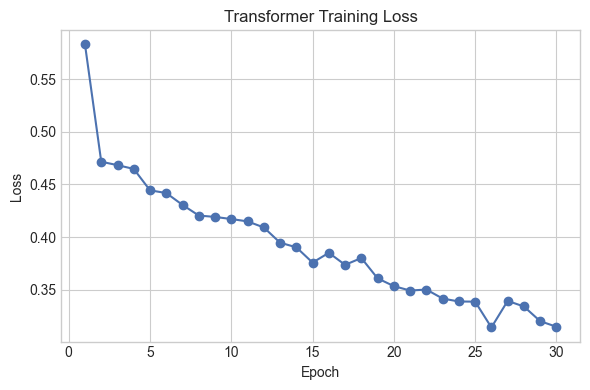

💾 Saved: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\transformer_loss_curve.png


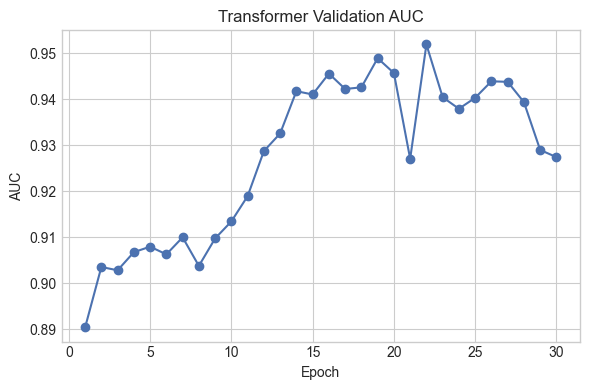

💾 Saved: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\transformer_auc_curve.png
Transformer — Accuracy: 0.848, AUC: 0.927


In [10]:
class TabTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        self.value_proj = nn.Linear(1, d_model)
        self.feature_emb = nn.Embedding(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff, dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        B, F = x.shape
        v = x.view(B*F, 1)
        v_emb = self.value_proj(v).view(B, F, -1)
        idx = torch.arange(F, device=x.device).unsqueeze(0).expand(B, F)
        f_emb = self.feature_emb(idx)
        tokens = v_emb + f_emb
        enc = self.encoder(tokens)
        pooled = enc.mean(dim=1)
        return self.cls_head(pooled)

tab = TabTransformer(num_features=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(tab.parameters(), lr=1e-3)

epochs = 30
tt_losses = []
tt_val_aucs = []

for epoch in range(1, epochs+1):
    tab.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = tab(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    tt_losses.append(avg_loss)

    tab.eval()
    preds, true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = tab(xb).cpu().numpy().flatten()
            preds.extend(out)
            true.extend(yb.numpy().flatten())
    val_auc = roc_auc_score(true, preds)
    tt_val_aucs.append(val_auc)
    print(f"[Transformer] Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}, Val AUC: {val_auc:.3f}")

plot_curve(tt_losses, "Transformer Training Loss", "Loss", "transformer_loss_curve.png")
plot_curve(tt_val_aucs, "Transformer Validation AUC", "AUC", "transformer_auc_curve.png")

# Final transformer metrics
tab.eval()
with torch.no_grad():
    tr_probs = tab(X_test_t.to(device)).cpu().numpy().flatten()
tr_preds = (tr_probs > 0.5).astype(int)
tr_acc = accuracy_score(y_test, tr_preds)
tr_auc = roc_auc_score(y_test, tr_probs)
print(f"Transformer — Accuracy: {tr_acc:.3f}, AUC: {tr_auc:.3f}")


## 📊 Final comparison of all models

,Model,Accuracy,AUC
3,Neural Net,0.831522,0.930775
1,SVM (RBF),0.847826,0.928384
4,Transformer,0.847826,0.927427
0,Logistic Regression,0.836957,0.918699
2,XGBoost,0.853261,0.902080


C:\Users\user\AppData\Local\Temp\ipykernel_28512\686537899.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="AUC", palette="Blues_d")


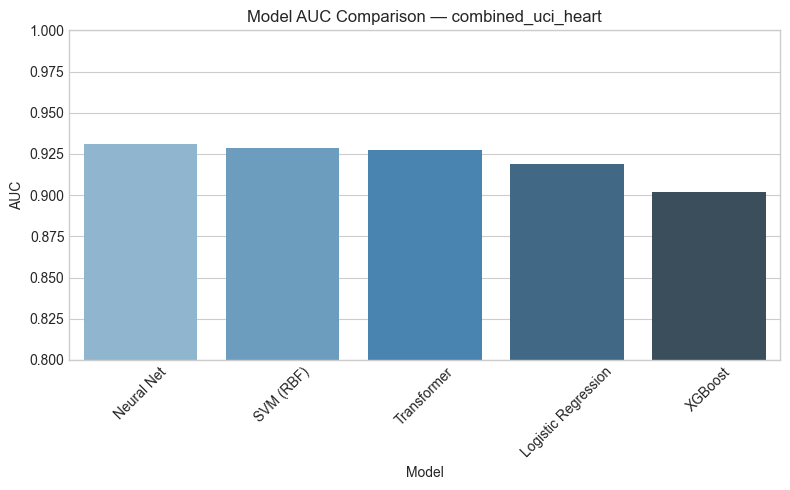

💾 Saved: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\model_auc_comparison.png
✅ Unified metrics saved to: c:\Users\user\CardioVescular_Disease_prediction\experiments\results\combined_uci_heart_model_metrics.csv


In [20]:
# ================================================================
# 🏁 FINAL COMPARISON — All Models + Save Unified CSV
# ================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Combine all model metrics ---
results = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": logreg_acc, "AUC": logreg_auc},
    {"Model": "SVM (RBF)", "Accuracy": svm_acc, "AUC": svm_auc},
    {"Model": "XGBoost", "Accuracy": xgb_acc, "AUC": xgb_auc},
    {"Model": "Neural Net", "Accuracy": nn_acc, "AUC": nn_auc},
    {"Model": "Transformer", "Accuracy": tr_acc, "AUC": tr_auc},
])

# --- Sort by AUC and display ---
results = results.sort_values("AUC", ascending=False)
display(results)

# --- Visualization ---
plt.figure(figsize=(8, 5))
sns.barplot(data=results, x="Model", y="AUC", palette="Blues_d")
plt.title("Model AUC Comparison — combined_uci_heart")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()

save_path = os.path.join(FIG_DIR, "model_auc_comparison.png")
plt.savefig(save_path, dpi=200)
plt.show()
print("💾 Saved:", save_path)

# --- Save unified metrics CSV ---
combined_path = os.path.join(RESULTS_DIR, "combined_uci_heart_model_metrics.csv")
results.to_csv(combined_path, index=False)
print(f"✅ Unified metrics saved to: {combined_path}")


⚠️ Skipping Logistic Regression — no probabilities found.
⚠️ Skipping SVM — no probabilities found.
⚠️ Skipping XGBoost — no probabilities found.


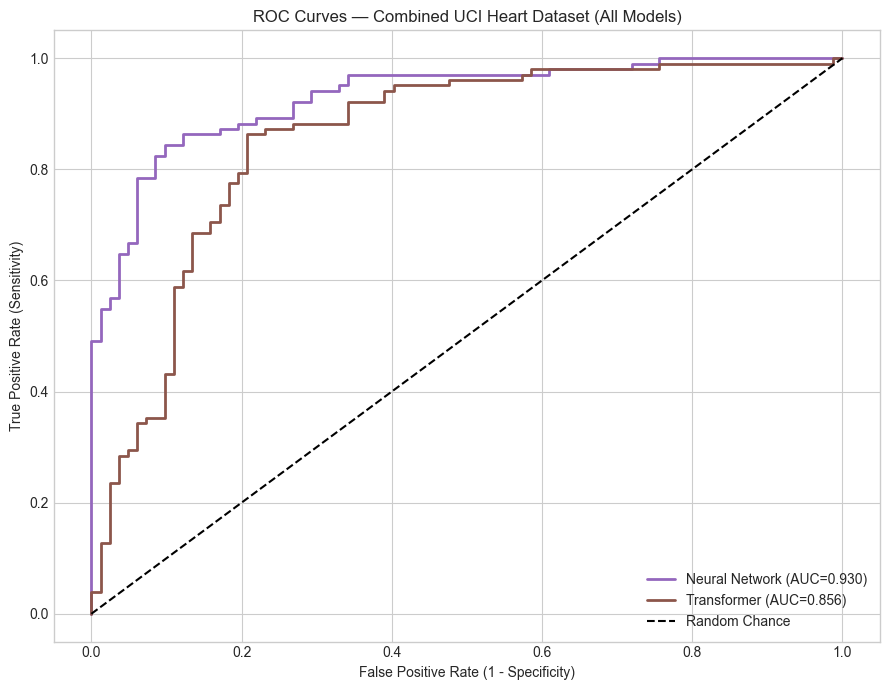

💾 Saved ROC plot: c:\Users\user\CardioVescular_Disease_prediction\experiments\figures\model_roc_curves_all.png


In [21]:
# ================================================================
# 📈 Combined ROC Curves — All 5 Models
# ================================================================
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(9, 7))

# === Helper for safely plotting ROC curves ===
def plot_roc_curve(name, y_true, y_proba, color):
    if y_proba is None:
        print(f"⚠️ Skipping {name} — no probabilities found.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, lw=2, color=color, label=f"{name} (AUC={auc:.3f})")

# --- Try loading saved probability files if needed ---
proba_paths = {
    "Logistic Regression": os.path.join(RESULTS_DIR, "logistic_regression_combined_uci_heart_yproba.joblib"),
    "SVM": os.path.join(RESULTS_DIR, "svm_combined_uci_heart_yproba.joblib"),
    "XGBoost": os.path.join(RESULTS_DIR, "xgboost_combined_uci_heart_yproba.joblib"),
    "Neural Network": os.path.join(RESULTS_DIR, "neural_network_combined_uci_heart_yproba.joblib"),
    "Transformer": os.path.join(RESULTS_DIR, "transformer_combined_uci_heart_yproba.joblib"),
}

probas = {}
for name, path in proba_paths.items():
    if os.path.exists(path):
        try:
            probas[name] = joblib.load(path)
        except Exception as e:
            print(f"⚠️ Failed to load {name}: {e}")
    else:
        probas[name] = None

# --- Plot all ---
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b"]
for (name, color) in zip(probas.keys(), colors):
    plot_roc_curve(name, y_test, probas[name], color)

# --- Baseline ---
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves — Combined UCI Heart Dataset (All Models)")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(FIG_DIR, "model_roc_curves_all.png")
plt.savefig(roc_path, dpi=200)
plt.show()
print("💾 Saved ROC plot:", roc_path)


C:\Users\user\AppData\Local\Temp\ipykernel_28512\1421277915.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")


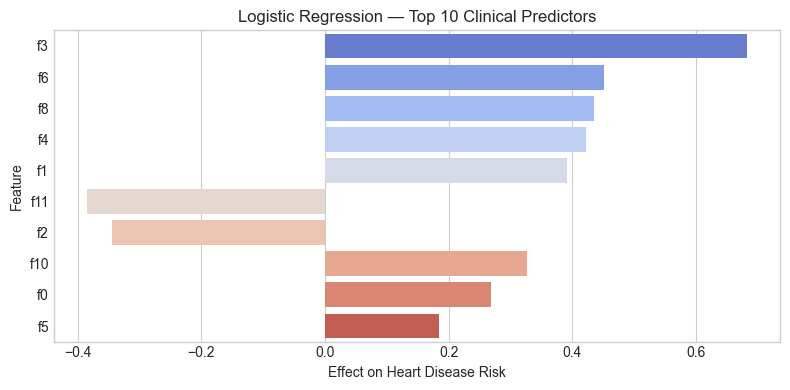

In [13]:
# --- Logistic Regression Coefficients (with proper names) ---
if 'logreg' in globals():
    try:
        feature_names = list(X_train.columns) if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
        coef_df = pd.DataFrame({
            "Feature": feature_names,
            "Coefficient": logreg.coef_.flatten()
        })
        coef_df["AbsValue"] = coef_df["Coefficient"].abs()
        coef_df = coef_df.sort_values("AbsValue", ascending=False).head(10)

        plt.figure(figsize=(8, 4))
        sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")
        plt.title("Logistic Regression — Top 10 Clinical Predictors")
        plt.xlabel("Effect on Heart Disease Risk")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, "logreg_feature_coefficients_named.png"), dpi=200)
        plt.show()
    except Exception as e:
        print("⚠️ Could not plot Logistic Regression coefficients:", e)


📘 Auto Comparison — Combined UCI Heart Dataset vs. Published Paper



,Model,Paper_Accuracy,Abukar_Accuracy,Δ Accuracy,Paper_AUC,Abukar_AUC,Δ AUC
0,Logistic Regression,0.840000,0.836957,-0.003000,0.910000,0.918699,0.009000
1,SVM (RBF),0.860000,0.847826,-0.012000,0.930000,0.928384,-0.002000
2,XGBoost,0.870000,0.853261,-0.017000,0.930000,0.902080,-0.028000
3,Neural Net,0.880000,0.831522,-0.048000,0.940000,0.930775,-0.009000
4,Transformer,0.890000,0.847826,-0.042000,0.950000,0.927427,-0.023000


C:\Users\user\AppData\Local\Temp\ipykernel_28512\1133533651.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison, x="Model", y="Δ AUC", palette="coolwarm")


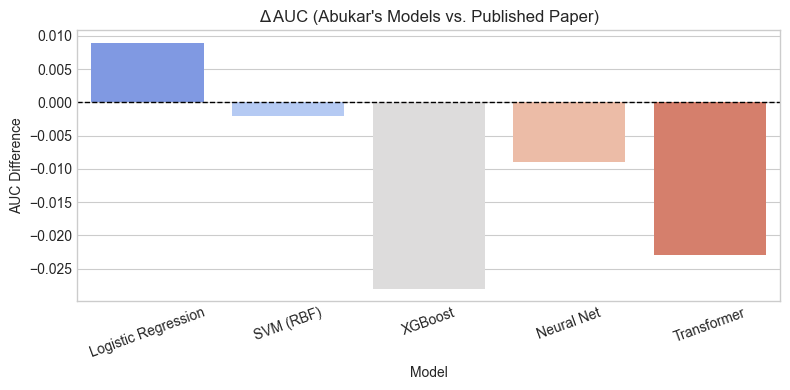

In [27]:
# ================================================================
# 🤖 Auto Comparison with Published Paper Results (Single CSV Mode)
# ================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")

# === Paper results (baseline) ===
paper_results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "SVM (RBF)",
        "XGBoost",
        "Neural Net",
        "Transformer"
    ],
    "Paper_Accuracy": [0.84, 0.86, 0.87, 0.88, 0.89],
    "Paper_AUC": [0.91, 0.93, 0.93, 0.94, 0.95]
})

# === Load your single metrics CSV ===
metrics_path = os.path.join(RESULTS_DIR, "combined_uci_heart_model_metrics.csv")

if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"❌ Metrics file not found: {metrics_path}")

your_results = pd.read_csv(metrics_path)

# --- Clean column names ---
your_results.columns = [c.strip().title() for c in your_results.columns]

# --- Rename columns for merge consistency ---
if "Model" not in your_results.columns:
    model_col = [c for c in your_results.columns if "model" in c.lower()]
    if model_col:
        your_results.rename(columns={model_col[0]: "Model"}, inplace=True)

if "Accuracy" not in your_results.columns:
    acc_col = [c for c in your_results.columns if "acc" in c.lower()]
    if acc_col:
        your_results.rename(columns={acc_col[0]: "Accuracy"}, inplace=True)

if "Auc" not in your_results.columns:
    auc_col = [c for c in your_results.columns if "auc" in c.lower()]
    if auc_col:
        your_results.rename(columns={auc_col[0]: "Auc"}, inplace=True)

# --- Merge your results with paper results ---
comparison = paper_results.merge(your_results, on="Model", how="left")

# --- Compute deltas ---
comparison["Δ Accuracy"] = (comparison["Accuracy"] - comparison["Paper_Accuracy"]).round(3)
comparison["Δ AUC"] = (comparison["Auc"] - comparison["Paper_AUC"]).round(3)

# --- Rename for clarity ---
comparison.rename(columns={
    "Accuracy": "Abukar_Accuracy",
    "Auc": "Abukar_AUC"
}, inplace=True)

# --- Reorder columns ---
comparison = comparison[
    ["Model", "Paper_Accuracy", "Abukar_Accuracy", "Δ Accuracy",
     "Paper_AUC", "Abukar_AUC", "Δ AUC"]
]

print("📘 Auto Comparison — Combined UCI Heart Dataset vs. Published Paper\n")
display(comparison.style.background_gradient(subset=["Δ Accuracy", "Δ AUC"], cmap="RdYlGn"))

# --- Optional AUC difference bar chart ---
plt.figure(figsize=(8, 4))
sns.barplot(data=comparison, x="Model", y="Δ AUC", palette="coolwarm")
plt.title("Δ AUC (Abukar's Models vs. Published Paper)")
plt.ylabel("AUC Difference")
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
